

Goal: need to be able to measure delta time of two identical but time delayed signals to within 3e-8 seconds

In [1]:
freq = 123.456

In [2]:
import numpy as np
import scipy.signal as sig
import scipy.fftpack as fft
import matplotlib.pyplot as plt

In [3]:
import scipy

In [4]:
import sys
!{sys.executable} -m pip install samplerate

In [5]:
import samplerate

In [6]:
transmitTime = 0.020

In [7]:
goal = 3 * (10 ** (-8))

In [8]:
sampleRate = 2 * (10 ** 6)

In [9]:
c = 3 * (10 ** 8)

Assuming two perfectly synchronized receivers $(R_1, R_2)$, located at $(x_1, y_1)$ and $(x_2, y_2)$ 

In [10]:
# Ground truth transmitter location to be fixed, I have not yet calculated target location based on time offsets set below 
# (or I could calculate expected offsets based on location difference)
x_target = 0
y_target = 0

x_1 = 0
x_2 = 0

y_1 = 25
y_2 = -50

In [258]:
def produceExampleSignal(sampleRate, offsetTime, transmitTime, freq, amp ):
    duration = offsetTime + transmitTime
    num_tot_samples = sampleRate * duration
    num_samples = sampleRate * transmitTime
    t = np.arange(num_samples) / sampleRate
    t_tot = np.arange(num_tot_samples) / sampleRate
    x = amp * np.sin(2 * np.pi * (freq * t - phase)) 
    new = np.zeros(int(sampleRate * offsetTime))
    x = np.concatenate((new, np.array(x)))
    return x, t_tot

In [11]:
def createCpxTestSignal(frequencies, amplitudes, delays, lengths, sampling_frequency, signal_length)->np.ndarray:
    assert(len(frequencies) == len(amplitudes) == len(delays) == len(lengths))
    tIdx = np.arange(0, signal_length, 1/sampling_frequency)
    signal = np.zeros(len(tIdx), dtype=np.complex64)
    for i in range(len(frequencies)):
        component = np.sin(2 * np.pi * frequencies[i] * (tIdx + delays[i])) + 1j * np.cos(2 * np.pi * frequencies[i] * (tIdx + delays[i]))
        rectangle = (delays[0] < tIdx) & (tIdx < (delays[0] + lengths[0]))
        signal += amplitudes[i] * component * rectangle
    return signal, tIdx

In [12]:
frequencies = [1e4]
amplitudes = [0.5]
delays = [20e-8]
lengths = [40e-3]
sampling_frequency = 2e6
signal_length = 0.05

x, t = createCpxTestSignal(frequencies, amplitudes, [0e-8], lengths, sampling_frequency, signal_length)
x_1, t1 = createCpxTestSignal(frequencies, amplitudes, [10e-8], lengths, sampling_frequency, signal_length)
x_2, t2 = createCpxTestSignal(frequencies, amplitudes, delays, lengths, sampling_frequency, signal_length)
x_3, t3 = createCpxTestSignal(frequencies, amplitudes, [30e-8], lengths, sampling_frequency, signal_length)
x_4, t4 = createCpxTestSignal(frequencies, amplitudes, [40e-8], lengths, sampling_frequency, signal_length)

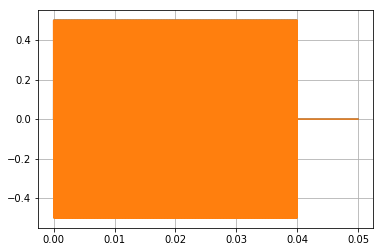

In [13]:
plt.plot(t, np.real(x_1))
plt.plot(t, np.imag(x_1))
plt.grid()

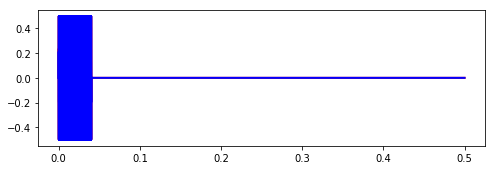

In [173]:
plt.figure(figsize=(8, 2.5))
plt.plot(t2, x_2, color='red', linewidth=2.0, linestyle='-')
plt.plot(t2, x_1, color='blue', linewidth=2.0, linestyle='-')

ValueError: x and y must have same first dimension, but have shapes (1000000,) and (100001,)

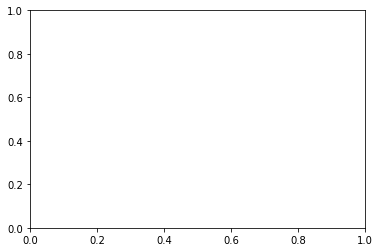

In [174]:
plt.plot(t, np.real(testSignal2))
plt.plot(t, np.imag(testSignal2))
plt.grid()

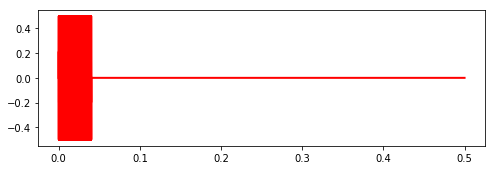

In [175]:
plt.figure(figsize=(8, 2.5))
plt.plot(t, x_1, color='red', linewidth=2.0, linestyle='-')

Assume $R_1$ is used as a reference sensor

In [191]:
#sample sinusoid with offset
#these represent absolute offsets from the start of recording time of Receiver 1

offset_1 = .005
offset_2 = .010

#sample for 50ms, while signal is transitted for 20ms, assume sinusoid is centered at 0
amp = 1
phase = 0

x_1, t_1 = produceExampleSignal(sampleRate, offset_1, transmitTime, freq, amp)

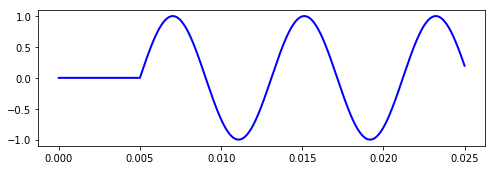

In [192]:
plt.figure(figsize=(8, 2.5))
plt.plot(t_1, x_1, color='blue', linewidth=2.0, linestyle='-')

In [193]:
x_2, t_2 = produceExampleSignal(sampleRate, offset_2, transmitTime, freq, 1.5)

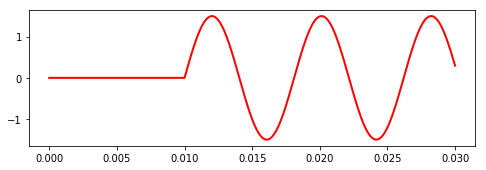

In [194]:
plt.figure(figsize=(8, 2.5))
plt.plot(t_2, x_2, color='red', linewidth=2.0, linestyle='-')

#### The following alignment process is a simple case following methods details here: https://blog.endaq.com/synchronizing-signals

In [138]:
#resample both signals to 3*10^8 sampling rate
#Due to memory issues, I brought sampling rate down to 2*10^4, and goal down to 3*10^7 in order
#to keep ratio between the two at 150
res_x_1 = samplerate.resample(x_1, 150, 'linear')
res_t_1 = samplerate.resample(t, 150, 'linear')
res_x_2 = samplerate.resample(x_2, 150, 'linear')
res_t_2 = samplerate.resample(t2, 150, 'linear')

In [120]:
delay = np.argmax(np.correlate(x_1, x_2))
delay

0

In [14]:
res_x_1 = x_1
res_x_2 = x_2

In [15]:
x_1_peaks, x_1_properties = sig.find_peaks(res_x_1)
x_2_peaks, x_2_properties = sig.find_peaks(res_x_2)

C:\Users\mluci\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [16]:
x_1_troughs, x_1_properties = sig.find_peaks(-res_x_1)
x_2_troughs, x_2_properties = sig.find_peaks(-res_x_2)

In [17]:
print(x_1_peaks[2])
print(x_2_peaks[2])

450
450


In [18]:
print(res_x_1[x_1_peaks[2]])
print(res_x_2[x_2_peaks[2]])

(0.49999014-0.003141572j)
(0.4999605-0.00628302j)


In [19]:
A = fft.fft(res_x_1)
B = fft.fft(res_x_2)
Ar = -A.conjugate()
Br = -B.conjugate()
np.argmax(np.abs(fft.ifft(Ar*B)))

0

In [20]:
np.argmax(sig.correlate(x_1,x_2))

C:\Users\mluci\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\mluci\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


100000

In [21]:
len(x_1)

100001

In [22]:
def getDiff(x1, x2): 
    # Find Points of interest and average distance between points
    res_x_1 = x1
    res_x_2 = x2
    x_1_peaks, x_1_properties = sig.find_peaks(res_x_1)
    x_2_peaks, x_2_properties = sig.find_peaks(res_x_2)
    x_1_troughs, x_1_properties = sig.find_peaks(-res_x_1)
    x_2_troughs, x_2_properties = sig.find_peaks(-res_x_2)
    avg = 0
    for i in range(len(x_1_peaks)):
        if i < len(x_2_peaks):
            diff = x_1_peaks[i] - x_2_peaks[i]
            avg += diff
    for i in range(len(x_1_troughs)):
        if i < len(x_2_troughs):
            diff = x_1_troughs[i] - x_2_troughs[i]
            avg += diff
    avg = avg / (len(x_1_peaks)+len(x_1_troughs))
    print('\nFinal Average:')
    print(avg)
    return avg

In [23]:
#align signals using average difference between points of interest
def alignSignals(sig1, sig2, offset):
    newSig1 = sig1
    newSig2 = sig2
    if offset < 0:
        newSig2 = sig2[-offset:]
    if offset > 0:
        newSig1 = sig1[offset:]   
    return newSig1, newSig2

In [56]:
differences = []

In [57]:
differences.append(getDiff(x, x_1))


Final Average:
0.0


In [58]:
differences.append(getDiff(x_1, x_2))


Final Average:
0.0


In [59]:
differences.append(getDiff(x_1, x_3))


Final Average:
0.9987515605493134


In [60]:
differences.append(getDiff(x_1, x_4))


Final Average:
0.9987515605493134


In [30]:
avg = differences[1]

In [31]:
aligned_1, aligned_2 = alignSignals(res_x_1, res_x_2, int(avg))

<IPython.core.display.Javascript object>


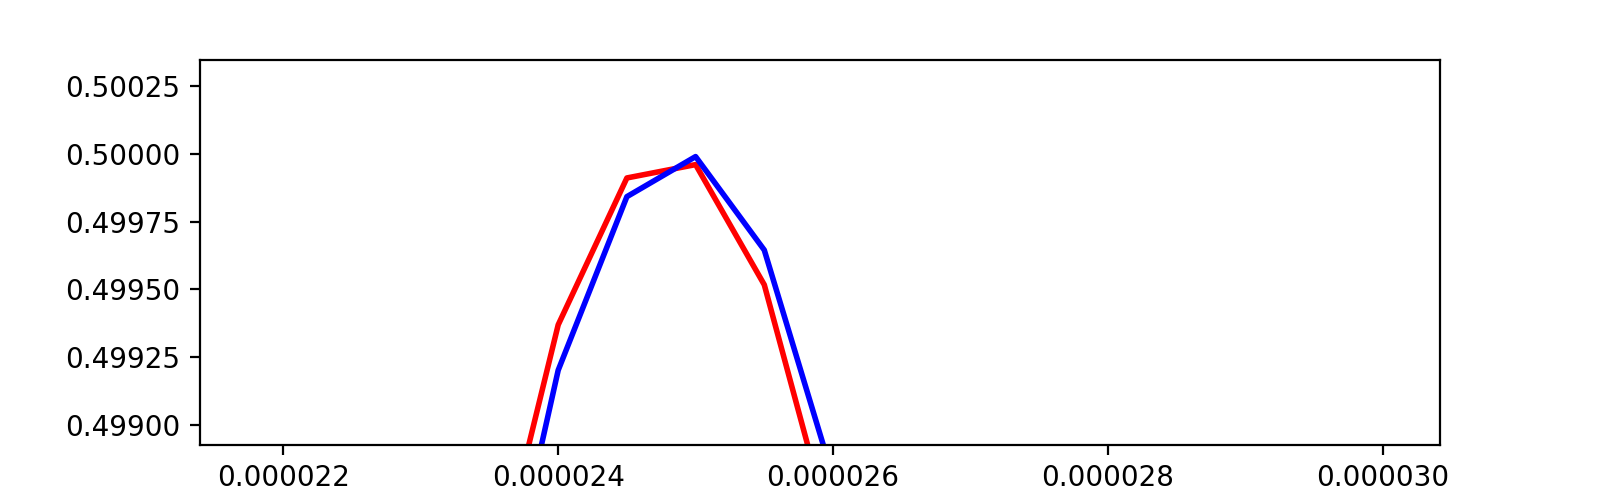

In [37]:
'''
plt.figure(figsize=(8, 2.5))
plt.plot(res_t_2, aligned_2, color='red', linewidth=2.0, linestyle='-')
plt.figure(figsize=(8, 2.5))
plt.plot(res_t_1[0:int(-avg)], aligned_1, color='blue', linewidth=2.0, linestyle='-')
'''
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2.5))
plt.plot(t2, aligned_2, color='red', linewidth=2.0, linestyle='-')
plt.plot(t1, aligned_1, color='blue', linewidth=2.0, linestyle='-')

Factors currently unaccounted for in simple case:

- noise
- differences in actual sampling rate
- differences in received transmitter frequency
- differences in received signal transmission length?
- actual sampling rate and goal not used because of memory limitations(displaying resampled data was too much for my laptop)
- In a lot of my functions I assumed receiver 1 would receive the signal first

In [62]:
differences = delay - (np.array(differences)/2e6)

In [63]:
differences

array([ 1.00000000e-07,  2.00000000e-07, -1.99375780e-07, -9.93757803e-08])

In [55]:
delay = np.array([10e-8, 20e-8, 30e-8, 40e-8])

<IPython.core.display.Javascript object>


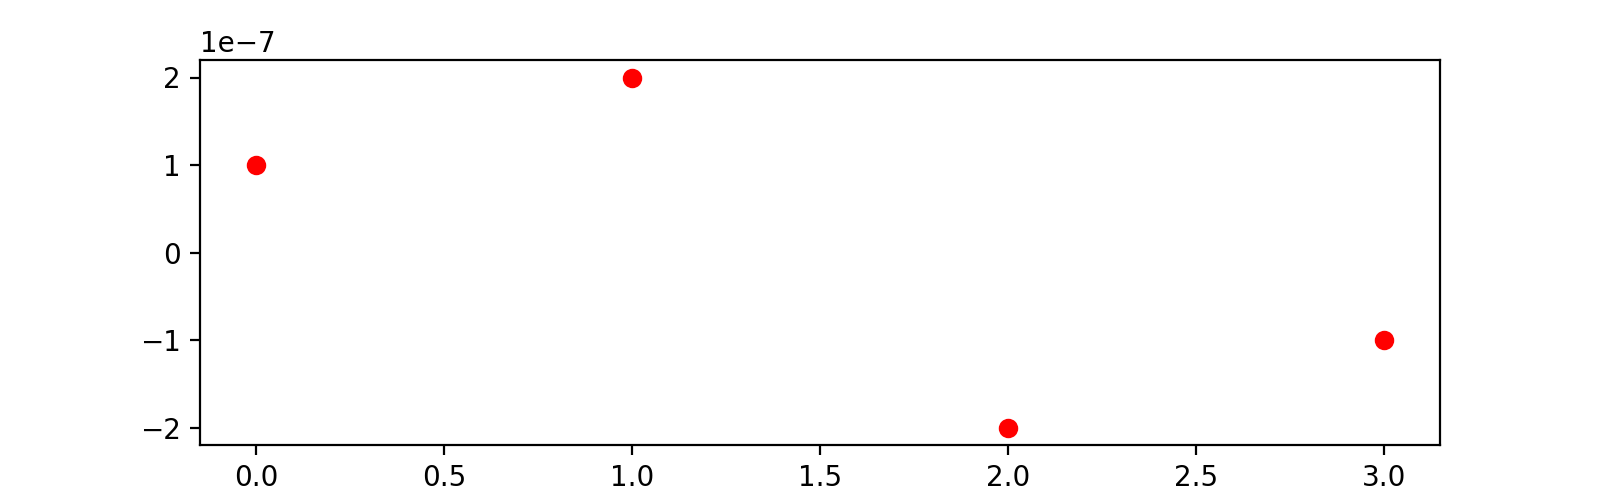

In [64]:
plt.figure(figsize=(8, 2.5))
plt.plot([0, 10e-8, 20e-8, 30e-8], differences, 'ro')